In [1]:
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io

In [2]:
def read_tdms(tdms_file, datalen):
    ncol = int(tdms_file.properties['strips'])
    bot_pix = int(tdms_file.properties['bottom pixel'])
    top_pix = int(tdms_file.properties['top pixel'])
    nrow = int(bot_pix - top_pix + 1)
    data_cube = np.zeros((int(ncol*nrow), datalen))
    idx = 0
    for group in tdms_file.groups():
        group_name = group.name
        for channel in group.channels():
            channel_name = channel.name
            properties = channel.properties
            data = channel[:]
            data_cube[idx,:] = data
            idx = idx + 1
        break
    data_cube = np.reshape(data_cube, ((ncol, nrow, datalen)))
        
    for group in tdms_file.groups():
        group_name = group.name
        if group_name == 'Spectra':
            continue
        for channel in group.channels():
            channel_name = channel.name
            properties = channel.properties
            waves = channel[:]
            break    
        
    return bot_pix, top_pix, waves, data_cube

In [3]:
path_int = '241221/nps_in_glycerol/mg110_glyc_33.tdms'
pathbc = '241221/nps_in_glycerol/mg110_glyc_WC34.tdms'
pathdc = '241221/nps_in_glycerol/mg110_glyc_DC35.tdms'

positions = np.loadtxt('241221/nps_in_glycerol/mg110_glyc_33/positions.txt')
numPart = len(positions)
bot_pix, top_pix, wave_raw, inten_raw = read_tdms(tdms_file=TdmsFile.read(path_int), datalen=670)
_, _, w1, dc_raw =     read_tdms(tdms_file=TdmsFile.read(pathdc), datalen=1340)
_, _, w2, bc_raw =    read_tdms(tdms_file=TdmsFile.read(pathbc),  datalen=1340)

dc = np.mean(dc_raw, 0)
bc = np.mean(bc_raw, 0)

stan = bc - dc 
stan = stan - np.min(stan) + 0.1 

stanim = np.zeros(inten_raw.shape)
for i in range(inten_raw.shape[0]):
    stanim[i,:,:] = stan[top_pix-1:bot_pix,::2]

In [4]:
scaled = 1000
def fit_2Dgauss(M, a, x0, c1, y0, c2, d):
    x, y = M
    return 1E3*a*np.exp(-((x-x0)**2 / (2*(c1)**2) + (y-y0)**2 / (2*(c2)**2))) + d*scaled

In [5]:
def fit_the_NP_eachwave(specfin, waveidx, xi, yi):
    # Find the background at a given wavelength
    specfin = specfin[xi-10:xi+10, yi-10:yi+10, waveidx].T
    xrange = np.linspace(0, specfin.shape[0]-1, specfin.shape[0])
    yrange = np.linspace(0, specfin.shape[1]-1, specfin.shape[1])
    X, Y = np.meshgrid(xrange, yrange)
    xdata = np.vstack((X.ravel(), Y.ravel()))
    Z = specfin.ravel()
    p0 = [1., 10., 0.86, 10., 1., 2.]
    popt, pcov = curve_fit(fit_2Dgauss, xdata, Z, p0)
    fitdata = fit_2Dgauss(xdata, *popt).reshape(len(yrange), len(xrange))
    return specfin, fitdata, popt

In [6]:
wave_0 = 150
background = np.zeros((numPart, (len(wave_raw)-wave_0)))

for npi in range(numPart):
    xi = int(positions[npi,0])-1
    yi = int(positions[npi,1])-1
    
    for wavei in range(len(wave_raw)-wave_0):
        try:
            _, _, popt = fit_the_NP_eachwave(specfin=inten_raw, 
                                             waveidx=wavei+wave_0, 
                                             xi=int(positions[npi,0])-1, 
                                             yi=int(positions[npi,1])-1)
        except RuntimeError:
            pass
        background[npi, wavei] = np.round(popt[-1]*scaled, 1)
#     if npi > 14:
#         break

/Users/clairewest/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [7]:
def fit_lorentz(wave_eV, A, Gam_eV, wave0_eV):
    return A * 0.5 * Gam_eV / ((wave_eV-wave0_eV)**2 + (0.5*Gam_eV)**2)

Text(0.5, 0, 'Wavelength')

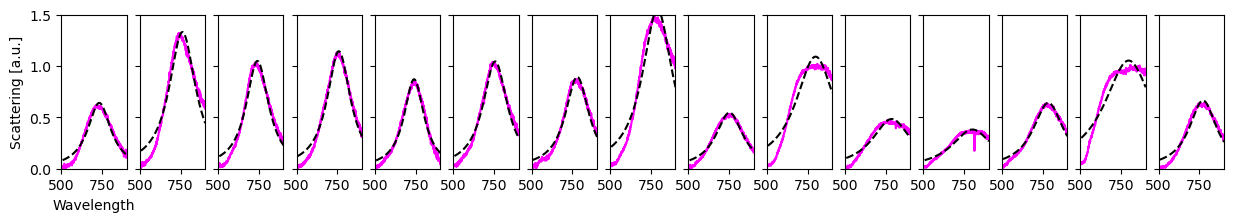

In [53]:
fig, ax = plt.subplots(1,15, figsize=[15,2],sharey=True, sharex=True)

gam_fit = np.zeros(numPart)
eres_fit = np.zeros(numPart)


for npi in range(numPart):
    xi = int(positions[npi,0])-1
    yi = int(positions[npi,1])-1
    
    specfin_fitbkd = (inten_raw[:,:,wave_0:] - background[npi,:]) / stanim[:,:,wave_0:]
    sum3_fitbkd = np.round((specfin_fitbkd[xi+1,yi-1,:]+specfin_fitbkd[xi,yi-1,:]+specfin_fitbkd[xi-1,yi-1,:]+
                   specfin_fitbkd[xi+1,yi,:]+  specfin_fitbkd[xi,yi,:]+  specfin_fitbkd[xi-1,yi,:]+
                   specfin_fitbkd[xi+1,yi+1,:]+specfin_fitbkd[xi,yi+1,:]+specfin_fitbkd[xi-1,yi+1,:]), 5)

    ax[npi].plot(wave_raw[wave_0:], sum3_fitbkd, color='magenta', label='Fit Background')
    popt, pcov = curve_fit(fit_lorentz, wave_raw[wave_0:], sum3_fitbkd,
                             p0=[100,200,770])#, bounds=[[0,0.1,1],[1,0.5,3]]) 

    ax[npi].plot(wave_raw[wave_0:], fit_lorentz(wave_raw[wave_0:], *popt), color='k', linestyle='--')
    gam_fit[npi] = popt[1]; eres_fit[npi] = popt[2]

    
# # plt.legend()
ax[0].set_xlim([500,900]);
ax[0].set_ylim([0,1.5]);
ax[0].set_ylabel('Scattering [a.u.]')
ax[0].set_xlabel('Wavelength')

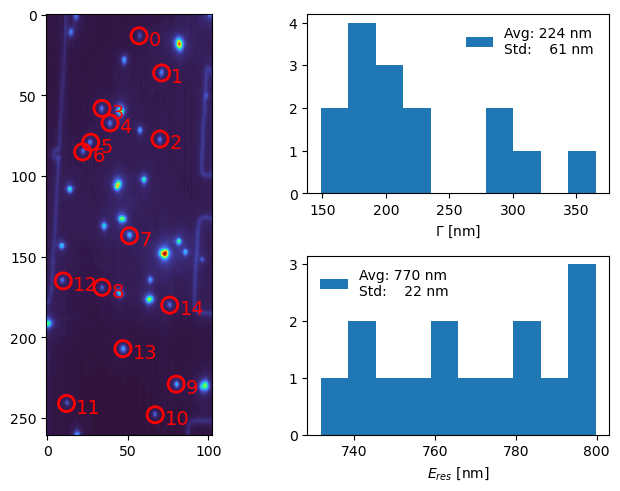

In [51]:
fig = plt.figure( constrained_layout=True)
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1,1])

for i in range(numPart):
    ax1.add_patch(plt.Circle([int(positions[i][0]-1), int(positions[i][1]-1)], radius=5, edgecolor='r',lw=2, fill=False))        
    ax1.annotate(str(i), fontsize=14, xy=[int(positions[i][0]+5), int(positions[i][1]+5)],color='red')


ax1.imshow(np.sum(inten_raw,2).T, cmap='turbo')


labelgam = str('Avg: ') + str(int(np.round(np.mean(gam_fit)))) + str(' nm \nStd:    ') + str(int(np.round(np.std(gam_fit)))) + str(' nm') 
ax2.hist(gam_fit, label=labelgam)

labeleres = str('Avg: ') + str(int(np.round(np.mean(eres_fit)))) + str(' nm \nStd:    ') + str(int(np.round(np.std(eres_fit)))) + str(' nm') 

ax3.hist(eres_fit, label=labeleres)


ax2.set_xlabel('$\Gamma$ [nm]')
ax3.set_xlabel('$E_{res}$ [nm]')

ax2.legend(frameon=False)
ax3.legend(frameon=False)